In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import trackbact as tb
import plotbact as pb

# Load the data

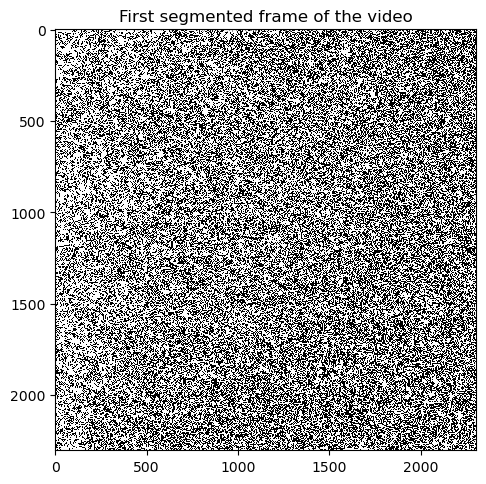

2304 2304


In [88]:
file_name="WT_dense_segmented.tif"
im=tb.load_tif(file_name, show=True)
tifdim1=im.shape[1]
tifdim2=im.shape[2]
print(tifdim1, tifdim2)

# Fit ellipses to the contours

Finding the contours of the bacteria...: 100%|███████████████████████████████████████| 201/201 [00:49<00:00,  4.07it/s]


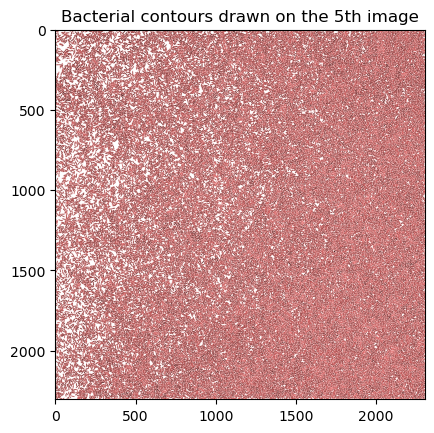

Fitting ellipses to the contours...: 100%|███████████████████████████████████████████| 201/201 [01:48<00:00,  1.86it/s]


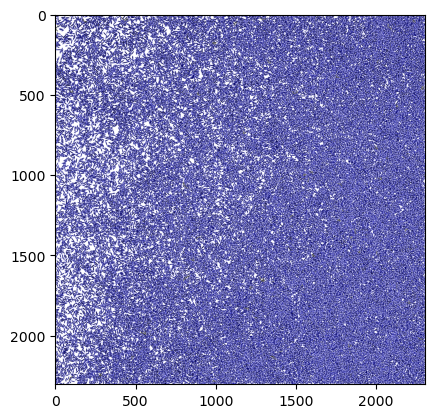

In [89]:
fitted_ellipses=tb.fit_ellipses(im, show_nth_frame=5, filter_max=(10,70))

# Format the data and plot the distribution of alignment angles

,x,y,frame,major_axis_size,minor_axis_size,body_angle
0,1115.566895,2304.526123,0,15.658649,6.449818,82.589149
1,1064.780518,2304.280273,0,24.930162,7.074800,83.235077
2,2151.646973,2301.705811,0,5.899429,3.630190,61.845036
3,1935.558228,2302.747803,0,19.563745,5.187518,88.954262
4,1835.119629,2301.681396,0,21.847427,3.444440,86.584702
...,...,...,...,...,...,...
8345880,136.654495,-0.182841,200,22.846252,5.662677,89.653580
8345881,31.551582,7.143306,200,23.277088,3.842240,44.404076
8345882,26.012835,1.511846,200,10.917605,3.980092,89.512642
8345883,17.000547,2.418560,200,6.286804,3.088333,143.523880


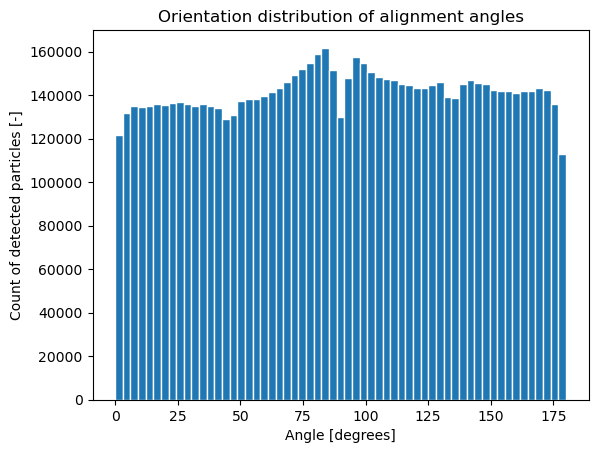

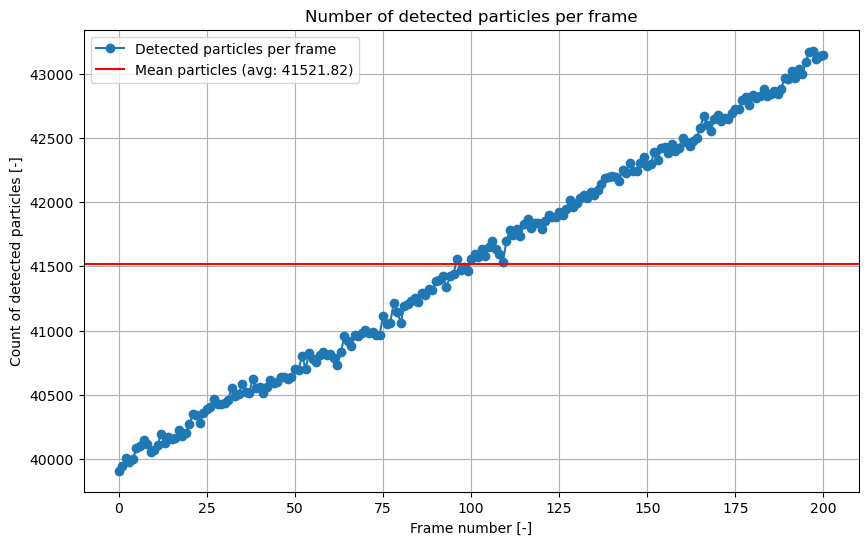

In [90]:
#format the fitted ellipses into a dataframe for tracking
ellipses_df=tb.format_ellipses(fitted_ellipses)
display(ellipses_df)

#For PIV analysis: Uncomment below to transform ellipses into single points
#tb.ellipse_to_particle(im, file_name, ellipses_df)


plt.hist(ellipses_df["body_angle"], bins=59, histtype='bar', ec='white')
plt.title("Orientation distribution of alignment angles")
plt.xlabel('Angle [degrees]')
plt.ylabel('Count of detected particles [-]')
plt.show()

# Count the number of particles per frame
particles_per_frame = ellipses_df.groupby('frame').size()

# Calculate the mean number of particles across all frames
mean_particles = particles_per_frame.mean()

# Plotting the number of detected particles per frame
plt.figure(figsize=(10,6))
plt.plot(particles_per_frame.index, particles_per_frame.values, marker='o', label='Detected particles per frame')  # Use plt.bar for a bar chart

# Plotting the mean number of particles as a horizontal line
plt.axhline(y=mean_particles, color='r', linestyle='-', label=f'Mean particles (avg: {mean_particles:.2f})')

# Adding titles and labels
plt.title('Number of detected particles per frame')
plt.xlabel('Frame number [-]')
plt.ylabel('Count of detected particles [-]')
plt.grid(True)
plt.legend()  # Show legend
plt.show()

In [91]:
import trackpy.diag
trackpy.diag.performance_report()

Yes, but could it be faster?
FAST: numba is available and enabled (fast subnets and feature-finding).


# Track the bacteria and write the results to disk

In [92]:
traj_tp = tb.track_bacteria(ellipses_df, max_search_range=10, min_search_range=2, filter=30)
display(traj_tp)
tb.write_trajectory(traj_tp, file_name)

Frame 200: 43148 trajectories present.


,particle,count
0,6115,201
1,24846,201
2,24543,201
3,24532,201
4,7829,201
...,...,...
72376,190313,31
72377,910,31
72378,221357,31
72379,190321,31


,x,y,frame,major_axis_size,minor_axis_size,body_angle,particle
0,1174.030029,798.905823,0,16.989994,5.582475,83.168381,1
1,1171.106201,799.063599,1,15.709252,4.207911,88.367325,1
2,1169.917358,798.801514,2,14.290728,4.607366,84.334679,1
3,1169.195435,799.090698,3,16.052017,4.147583,84.509705,1
4,1169.462402,799.141541,4,15.718956,4.456693,85.569725,1
...,...,...,...,...,...,...,...
6856306,1468.479492,1242.527344,196,9.894110,3.370069,163.478561,238381
6856307,1466.761230,1238.297607,197,22.466215,3.496117,159.016373,238381
6856308,1468.069702,1241.793701,198,10.057510,3.287212,166.101212,238381
6856309,1467.903076,1241.753540,199,10.091311,3.620003,166.976379,238381


# Load the results of the tracking

In [93]:
traj_loaded=tb.read_trajectory(file_name)
display(traj_loaded)

,x,y,frame,major_axis_size,minor_axis_size,body_angle,particle
0,1174.030029,798.905823,0,16.989994,5.582475,83.168381,1
1,1171.106201,799.063599,1,15.709252,4.207911,88.367325,1
2,1169.917358,798.801514,2,14.290728,4.607366,84.334679,1
3,1169.195435,799.090698,3,16.052017,4.147583,84.509705,1
4,1169.462402,799.141541,4,15.718956,4.456693,85.569725,1
...,...,...,...,...,...,...,...
6856306,1468.479492,1242.527344,196,9.894110,3.370069,163.478561,238381
6856307,1466.761230,1238.297607,197,22.466215,3.496117,159.016373,238381
6856308,1468.069702,1241.793701,198,10.057510,3.287212,166.101212,238381
6856309,1467.903076,1241.753540,199,10.091311,3.620003,166.976379,238381


# Plot trajectories

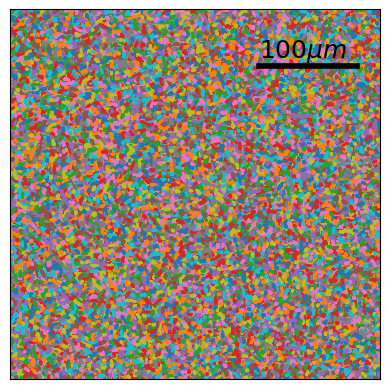

In [94]:
pb.plot_traj_all(traj_loaded, imdim1=tifdim1, imdim2=tifdim2, pix_size=0.1625)

# Calculate the kinematic parameters such as velocity and acceleration etc.

In [95]:
#Choose the appropriate time_step which is 1 for the dilute video and 3 for the dense ones.
particle_params=tb.calculate_kinematic_parameters(traj_tp, time_step=3)

display(particle_params)


tb.write_kinematics(particle_params, file_name)

100%|███████████████████████████████████████████████████████████████████████████| 72381/72381 [08:58<00:00, 134.29it/s]


,x [um],y [um],frame,major_axis_size [um],minor_axis_size [um],body_angle [degrees],particle,vx [um/s],vy [um/s],vel [um/s],ax [um/s^2],ay [um/s^2],acc [um/s^2],diff_body_angle [degrees],angular_vel [degrees/s],angular_acc [degrees/s^2]
0,190.779880,129.822196,0,2.760874,0.907152,83.168381,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,190.304758,129.847835,1,2.552754,0.683786,88.367325,1,-0.158374,0.008546,0.158604,NaN,NaN,NaN,5.198944,NaN,NaN
2,190.111571,129.805246,2,2.322243,0.748697,84.334679,1,-0.064396,-0.014196,0.065942,0.031326,-0.007581,0.032230,-4.032646,-3.077197,NaN
3,189.994258,129.852238,3,2.608453,0.673982,84.509705,1,-0.039104,0.015664,0.042125,0.008430,0.009953,0.013044,0.175026,1.402557,1.493251
4,190.037640,129.860500,4,2.554330,0.724213,85.569725,1,0.014461,0.002754,0.014721,0.017855,-0.004303,0.018366,1.060020,0.294998,-0.369186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6856306,238.627917,201.910693,196,1.607793,0.547636,163.478561,238381,0.017416,0.022561,0.028501,0.009164,0.010692,0.014082,-1.675812,-0.383931,0.445616
6856307,238.348700,201.223361,197,3.650760,0.568119,159.016373,238381,-0.093073,-0.229111,0.247294,-0.036830,-0.083890,0.091619,-4.462189,-0.928792,-0.181620
6856308,238.561327,201.791476,198,1.634345,0.534172,166.101212,238381,0.070876,0.189372,0.202200,0.054649,0.139494,0.149817,7.084839,3.849009,1.592601
6856309,238.534250,201.784950,199,1.639838,0.588250,166.976379,238381,-0.009026,-0.002175,0.009284,-0.026634,-0.063849,0.069181,0.875168,-2.069890,-1.972967


# Data analysis

To perform the analyse there is no need to run again all the code above but just need to load the _kinetimatic csv dataframes available on the google drive.

,x [um],y [um],frame,major_axis_size [um],minor_axis_size [um],body_angle [degrees],particle,vx [um/s],vy [um/s],vel [um/s],ax [um/s^2],ay [um/s^2],acc [um/s^2],diff_body_angle [degrees],angular_vel [degrees/s],angular_acc [degrees/s^2]
0,190.779880,129.822196,0,2.760874,0.907152,83.168381,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,190.304758,129.847835,1,2.552754,0.683786,88.367325,1,-0.158374,0.008546,0.158604,NaN,NaN,NaN,5.198944,NaN,NaN
2,190.111571,129.805246,2,2.322243,0.748697,84.334679,1,-0.064396,-0.014196,0.065942,0.031326,-0.007581,0.032230,-4.032646,-3.077197,NaN
3,189.994258,129.852238,3,2.608453,0.673982,84.509705,1,-0.039104,0.015664,0.042125,0.008430,0.009953,0.013044,0.175026,1.402557,1.493251
4,190.037640,129.860500,4,2.554330,0.724213,85.569725,1,0.014461,0.002754,0.014721,0.017855,-0.004303,0.018366,1.060020,0.294998,-0.369186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6856306,238.627917,201.910693,196,1.607793,0.547636,163.478561,238381,0.017416,0.022561,0.028501,0.009164,0.010692,0.014082,-1.675812,-0.383931,0.445616
6856307,238.348700,201.223361,197,3.650760,0.568119,159.016373,238381,-0.093073,-0.229111,0.247294,-0.036830,-0.083890,0.091619,-4.462189,-0.928792,-0.181620
6856308,238.561327,201.791476,198,1.634345,0.534172,166.101212,238381,0.070876,0.189372,0.202200,0.054649,0.139494,0.149817,7.084839,3.849009,1.592601
6856309,238.534250,201.784950,199,1.639838,0.588250,166.976379,238381,-0.009026,-0.002175,0.009284,-0.026634,-0.063849,0.069181,0.875168,-2.069890,-1.972967


Indexation of Groups (particles) and their reversals:
       Particle  Reversals
Index                     
0             1         33
1             2         58
2             3         84
3             4         28
4             6         13
...         ...        ...
72376    238370         14
72377    238372         12
72378    238374         14
72379    238377         10
72380    238381         18

[72381 rows x 2 columns]

Total number of unique particles: 72381

Average number of reversals: 29.419903013221703
Standard deviation of reversals: 19.94487667699601


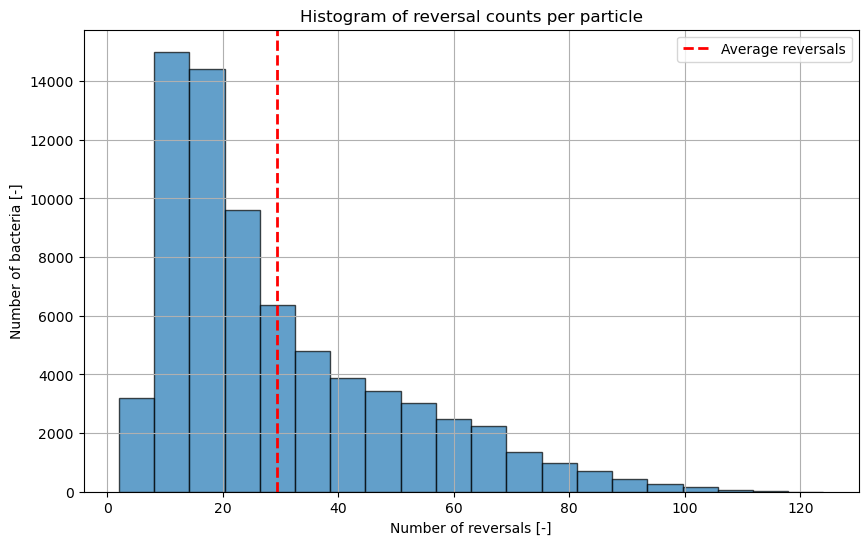

In [96]:
#To quantify reversal
loaded_params=tb.read_kinematics(file_name)
display(loaded_params)
pb.plot_reversals(loaded_params)

Mean velocities for each particle:
           vx [um/s]  vy [um/s]  vel [um/s]
particle                                  
1         -0.005716   0.002472    0.055908
2         -0.001690  -0.000667    0.038258
3         -0.000938  -0.000782    0.045634
4          0.012178   0.025933    0.105672
6         -0.032040  -0.031658    0.119644
...             ...        ...         ...
238370    -0.001309  -0.004944    0.033977
238372     0.016863   0.010428    0.068393
238374    -0.005378  -0.002565    0.127963
238377    -0.035743  -0.001733    0.061217
238381    -0.006051   0.000474    0.097971

[72381 rows x 3 columns]
Standard deviations for each particle:
           vx [um/s]  vy [um/s]  vel [um/s]
particle                                  
1          0.066758   0.033108    0.049375
2          0.057791   0.026840    0.050907
3          0.036374   0.066032    0.059929
4          0.084751   0.105510    0.088317
6          0.123357   0.106314    0.117517
...             ...        ...        

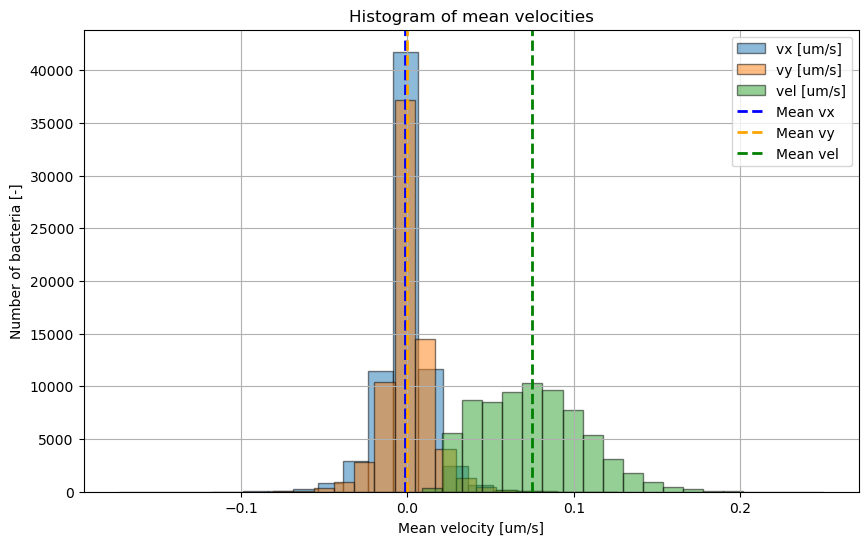

In [97]:
pb.plot_mean_velocities(loaded_params)

Total distance for each particle:
 particle
1         18.785234
2         20.429579
3         26.559092
4         19.654901
6         10.767984
            ...    
238370     3.057961
238372     6.155334
238374    11.516626
238377     5.509516
238381     8.817372
Name: distance, Length: 72381, dtype: float64
Mean trajectory length: 18.89287940069504
Standard deviation of trajectory length: 11.460195627444472


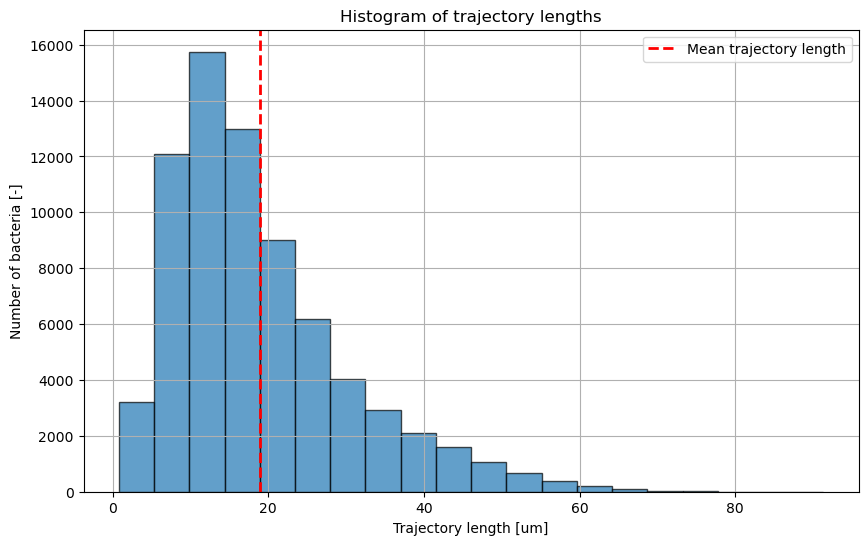

In [98]:
pb.plot_traj_length(loaded_params)

End-to-end trajectory length for each particle:
 particle
1         2.092402
2         0.970201
3         0.710513
4         5.328951
6         4.053814
            ...   
238370    0.460321
238372    1.784419
238374    0.536272
238377    3.220670
238381    0.546296
Length: 72381, dtype: float64
Mean end-to-end trajectory length: 3.379124628599693
Standard deviation of end-to-end trajectory length: 3.2156286360367465


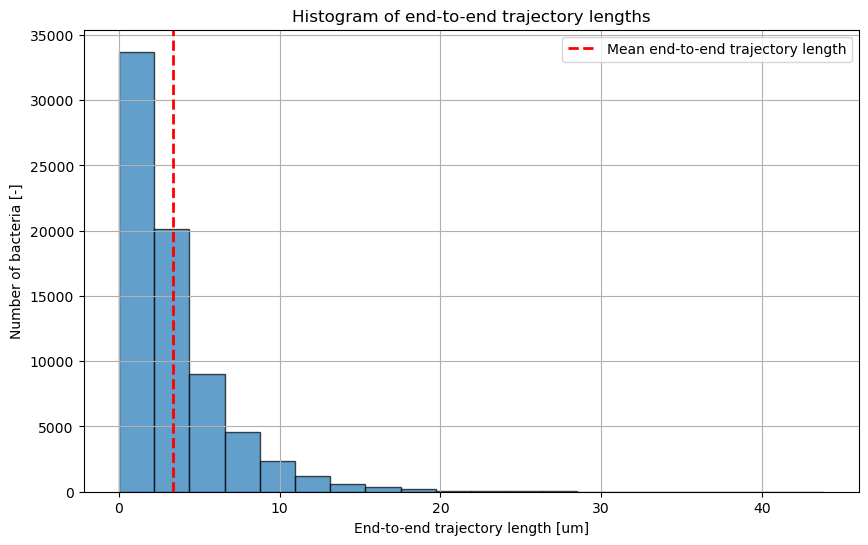

In [99]:
pb.plot_traj_end_to_end_lentgth(loaded_params)